**Getting Started**

This tutorial relies on standard python packages as well as [SimPEG](http://simpeg.xyz). If you do not have SimPEG installed, you can uncomment the next line and install it from [pypi](https://pypi.python.org/pypi/SimPEG).

The second package we are installing is [pymatsolver](https://github.com/rowanc1/pymatsolver), which interfaces to sparse matrix solvers. It is not required for the tutorial, we will fall-back to an LU solver, which is sufficient for this problem 

In [1]:
# !pip install SimPEG
# !pip install pymatsolver

# Inversion: 1D Magnetotelluric Problem

In the previous notebooks, we explored how to discretize the [1D MT problem](./1_MT1D_NumericalSetup.ipynb), how to design an appropriate mesh, and explored the [an example of non-uniquness](./2_MT1D_ForwardModellingAndNonuniqueness.ipynb). In this notebook, we will put those concepts to use and set up a 1D inversion. 

The aim of this notebook is to highlight the elements we use to set up and solve the inverse problem, in the notebook that follows this, we will dive futher into the impact of various parameter choices (eg. the trade-off parameter $\beta$, the stopping criteria, noise model and regulariztion parameters). 

## Inversion as Optimization

We will use deterministic approach and pose the inverse problem as an optimization problem of the form 

$$
\min_{\mathbf{m}} \phi(\mathbf{m}) = \phi_d(\mathbf{m}) + \beta\phi_m(\mathbf{m})
$$

where:
- $\mathbf{m}$ is our model - the vector of numbers that describes our earth model. It is what we are solving for in the inversion
- $\phi_d(\mathbf{m})$ is the data misfit
- $\phi_m(\mathbf{m})$ is the regularization
- $\beta$ is a trade-off parameter

### Data Misfit

The data misfit, $\phi_d(\mathbf{m})$, is often taken to be a weighted l2-norm, where the weights capture the noise model (eg. we want to assign higher weights and do a good job fitting data that we are confident are less noisy, and assign less weight / influence to data that are noisy). The l2 norm is the correct norm to choose when noise is Gaussian (or approximately Gaussian, or if you have no additional information and assume it is Gaussian). An l2 data misfit is captured mathematically by  

$$
\phi_d(\mathbf{m}) = \frac{1}{2}\|\mathbf{W_d} (\mathcal{F}(\mathbf{m}) - \mathbf{d}^{\text{obs}})\|^2
$$

where 

- $\mathbf{W_d} = \text{diag}(1/\boldsymbol{\epsilon})$ is a diagonal matrix with diagonal entries $1/\epsilon_i$, where $\epsilon_i$ is an estimated standard deviation of the $i$th datum.
- $\mathcal{F}$ is the forward modelling operator that simulates the 1D MT response given a model
- $\mathbf{m}$ is the model: the set of parameters which describe the physical properties of the layered earth
- $\mathbf{d}^{\text{obs}}$ is the observed data

(The factor of $1/2$ and the choice of using the squared-norm is a matter of convienence. We will be using gradient based optimzation methods, so it is easier to take derivatives of a norm squared than a norm.)

### Regularization
The inverse problem is an [ill posed problem](https://en.wikipedia.org/wiki/Well-posed_problem). There are multiple (actually infinitely many!) models that can fit the data.  There are a couple ways to observe this:

- Mathematically: If we start by thinking about a linear problem $\mathbf{G}\mathbf{m} = \mathbf{d}$, the matrix $\mathbf{G}$ is wide, so it is not directly invertible (eg. see Matt Hall's [Linear Inversion Tutorial](http://library.seg.org/doi/full/10.1190/tle35121085.1)). Here, we are dealing with a non-linear system of equations, but the principle is the same. 

- An Example: In the [Forward Modelling and Nonuniqueness notebook](2_MT1D_ForwardModellingAndNonuniqueness.ipynb), we used forward modelling to demonstrate non-uniquness with the conductivity-thickness product of a single, conductive layer, and this is a very simple model compared to most geologic settings! 

Thus, to choose from the infinitely many solutions and arrive at a sensible one, we employ a regularization: $\phi_m$. Tikhonov regularization, which again employs l2-norms, is a standard choice (It has a few nice features: it is convex and easy to differentiate). It takes the form: 
$$
\phi_m(\mathbf{m}) = \frac{1}{2}\big(\alpha_s\|\mathbf{W_s} (\mathbf{m} - \mathbf{m}_{\text{ref}})\|^2 + \alpha_z\|\mathbf{W_z} (\mathbf{m})\|^2 \big)
$$

The first term is often referred to as the "smallness" as it measures the "size" of the model (in the l2 sense). The matrix $\mathbf{W_s}$ is generally taken to be a diagonal matrix that may contain information about the length scales of the model or be used to weight the relative importance of various parameters in the model. The scalar $\alpha_s$ weights the relative importance of this term in the regularization. Notice that we include a reference model ($\mathbf{m}_{\text{ref}}$. Often this is defined as a constant value, but if more information is known about the background, that can be used to construct a reference model. Note that saying "I am not going to use a reference model" means that you are actually using $\mathbf{m}_{\text{ref}} = 0$, this is important to realize... in the inversion we demonstrate here, our `model` will be $\mathbf{m} = \text{log}(\sigma)$. If we set $\mathbf{m}_{\text{ref}} = 0$, then we are favoring models close to 1 S/m - which is quite conductive! 

The second term is often referred to as the "smoothness". The matrix $\mathbf{W_z}$ approximate the derivative of the model with respect to depth, and is hense a measure of how "smooth" the model is. The term $\alpha_z$ weights its relative importance in the regularization. 


## In this notebook...

Although we pose the inverse problem as an optimization problem, we aren't necessarily going to solve to a true minimum. There are always uncertainties with the data, so there is no point trying to drive $\phi_d$ to its true minimium - we would end up introducing structures in the model to fit the data (we will explore this here). So another choice that has to be made when setting up an inversion is where to stop. 

In this notebook, we will walk through how to set up an inversion, discuss concepts including:
- **Tikhonov curve**: a plot of $\phi_d$ vs $\phi_m$
- Defining a **target misfit** as a stopping criteria: $\phi_d^*$ and exploring what happens when we overfit or underfit the data
- Tuning the **regularization** ($\alpha_s$, $\alpha_z$): how _smooth_ or _small_ (in the L2-sense) do we want our model to be?

We will employ second-order optimization methods, meaning we have to be able to both simulate data and compute derivatives. We will take those steps for granted in this notebook, but if you are curious to look under the hood and see how sensitivities are computed for this problem, have a look at the [Sensitivities Notebook](./Appendix_A_MT1D_Sensitivity.ipynb).  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0
from SimPEG import (
    Mesh, Maps, SolverLU, DataMisfit, Regularization,
    Optimization, InvProblem, Inversion, Directives, Utils
)

try:
    from pymatsolver import PardisoSolver as Solver
except importError:
    from SimPEG import SolverLU as Solver

# the following are described in the Sensitivity notebooks
from MT1D import MT1DProblem, MT1DSurvey, MT1DSrc, ZxyRx, Survey, AppResPhaRx

%matplotlib inline

## Forward Simulation

### Parmeters
Now, we define our model parameters and survey setup. This includes defining
- location of receivers
- frequencies we are sampling
- type of dat we are measuring (impedance or apparent resistivity and phase)

Similar to the model shown in [1_MT1D_NumericalSetup.ipynb](./1_MT1D_NumericalSetup.ipynb) and [2_MT1D_ForwardModellingAndNonuniqueness](./2_MT1D_ForwardModellingAndNonuniqueness), we will start by considering a simple model which consists of 2 units: the background and a conductive layer (the layer). 

In [3]:
rho_half = 100.  # resistivity of the half space
rho_target = 10.  # resistivity of the target layer
depth = 2000.  # depth to the top of the target layer
thickness = 1000.   # thickness of the target layer

In [4]:
rxloc = np.r_[0.]   
frequency = np.logspace(-3, 2, 25)

### Survey
Next, we set up a `survey` object. Here we are following the SimPEG approach and define 
- a receiver object: given fields found from a simulation, it has the machinery to compute data. An impedance receiver `ZxyRx` calculates the ratio of $E_x$ and $H_y$ from calculated electric and magnetic fields (both real and imaginary components)
- a source object: this provides the right-hand-side for our MT problem. This is a plane wave source with at the specified frequency. 

These are combined in a `survey`. 

In [6]:
# Create a receiver object 
rx = ZxyRx(
    rxloc, # location of the receiver 
    component="both",  # measure both the real and imaginary components of the impedance (alternatively "real" / "imag")
    frequency=frequency
)

# create a plane wave source
src = MT1DSrc([rx])

# define a survey
survey = MT1DSurvey([src])

### Mesh

In the [Forward Modelling and Nonuniqueness notebook](2_MT1D_ForwardModellingAndNonuniqueness.ipynb), we discussed how to design a mesh that extends sufficiently far and has fine enough cells near the surface to accurately simulate the MT response across the frequency range of interest. We have wrapped up that knowledge in the utility function `setMesh` 

In [7]:
max_depth_core = 5000.
mesh = survey.setMesh(
    sigma=1./rho_half,  # conductivity of the background
    max_depth_core=max_depth_core,  # extent of the core region of the mesh
    ncell_per_skind=10,  # number of cells per the smallest skin depth
    n_skind=2,  # number of skin depths that the mesh should extend to ensure the lowest-frequency fields have decayed
    core_meshType = "linear",  # cell spacings in the core region of the mesh ("linear" or "log")
    max_hz_core=None  # If using a logarithmic core mesh, what is the maximum cell size?
)

>> Smallest cell size = 50 m
>> Padding distance = 316227 m
>> # of padding cells 28
>> # of core cells cells 100


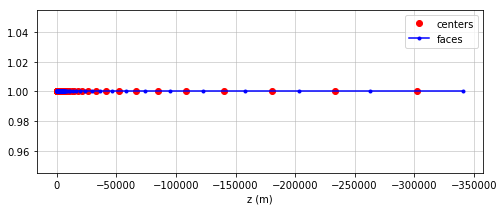

In [8]:
# plot the mesh
fig, ax = plt.subplots(1,1, figsize=(8, 3))
mesh.plotGrid(centers=True, faces=True, ax=ax)
ax.legend(["centers", "faces"])
ax.invert_xaxis()  # so that the surface is on our left hand side
ax.set_xlabel('z (m)')
ax.grid(which="both", linewidth=0.5)

### Problem

In the previous notebooks, we set up the machinery to solve the 1D MT problem. Here, we will use that functionality. Please see [Sensitivities Notebook](./3_MT1D_Sensitivity.ipynb) for further discussion on how `MT1DProblems` is set up. 

In [9]:
prob = MT1DProblem(
    mesh,  # The mesh contains the geometry, grids, etc necessary for constructing the discrete PDE system
    sigmaMap=Maps.ExpMap(mesh),  # in the inversion, we want to invert for log-conductivity (enforces postivity, electrical conductivity tends to vary logarithmically)
    verbose=False,  # print information as we are setting up and solving 
    Solver=Solver  # solver to employ for solving Ax = b
)

# tell the problem and survey about each other so we can construct our matrix system 
# and right hand-side
prob.pair(survey)

### Put the model on the mesh

In [10]:
sigma = np.ones(mesh.nC) * 1./rho_half

# find the layer
layer_inds = (mesh.vectorCCx<-depth)&(mesh.vectorCCx>-depth-thickness)
sigma[layer_inds] = 1./rho_target

(0, -5000.0)

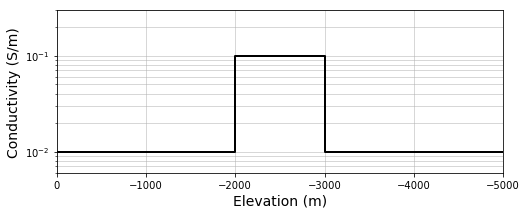

In [11]:
# plot the model
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

# trickery to plot from node to node rather than at cell centers
z = np.repeat(mesh.vectorNx[1:-1], 2, axis=0)
z = np.r_[mesh.vectorNx[0], z, mesh.vectorNx[-1]]
sigma_plt = np.repeat(sigma, 2, axis=0)

ax.semilogy(z, sigma_plt, "k", lw=2)
ax.invert_xaxis() # plot the surface on the left
ax.set_xlabel("Elevation (m)", fontsize=14)
ax.set_ylabel("Conductivity (S/m)", fontsize=14)
plt.grid(which='both', linewidth=0.5)
plt.ylim(6e-3, 3e-1)
plt.xlim(0, -max_depth_core)

## Simulate 'Observed' Data

Based on our model plotted above, we will create synthetic data. We will later use these data in the inversion. 

In [12]:
mtrue = np.log(sigma)  # since our "model" is log conductivity, we take the log
dtrue = survey.dpred(mtrue)  # these are clean data (no noise yet.)

Add noise to generate "observed" data

In [13]:
np.random.seed(1)  # set a seed to the results are reproducable
std = 0.05  # standard deviation of the noise (5%)

# data are arranged (apparent resistivity, phase) for each frequency
Zxy_real_true = dtrue.reshape((survey.nFreq, 2))[:,0]
Zxy_imag_true = dtrue.reshape((survey.nFreq, 2))[:,1]

# add noise
uncert = np.r_[
    abs(Zxy_real)*std, # uncertainty on real impedance
    abs(Zxy_imag)*std  # uncertainty on imag impedance
]
noise = uncert * np.random.randn(survey.nFreq*2)
survey.dobs = dtrue + noise

Zxy_real_obs = survey.dobs.reshape((survey.nFreq, 2))[:,0]
Zxy_imag_obs = survey.dobs.reshape((survey.nFreq, 2))[:,1]

In [ ]:
def app_res_phase(Zxy_real, Zxy_imag, frequency):
    app_res = abs(Zxy_real+1j*Zxy_imag)**2 / (mu_0*omega(frequency))
    phase = np.rad2deg(np.arctan(Zxy_imag / Zxy_real))
    return app_res, phase

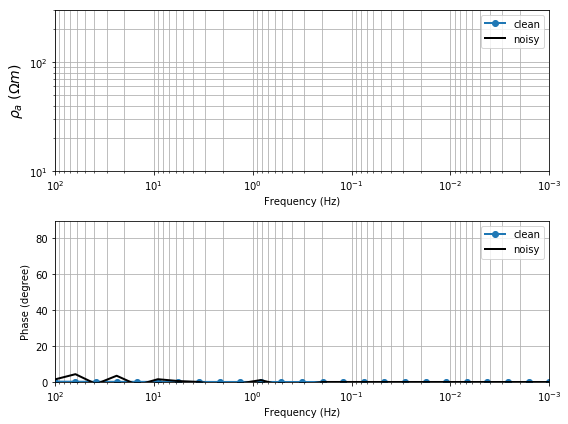

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(8,6))

# apparent resistivity
ax[0].loglog(frequency, app_res_true, '-o', lw=2, label="clean")
ax[0].loglog(frequency, app_res_obs, 'k-', lw=2, label="noisy")
ax[0].set_ylabel("$\\rho_a \ (\Omega m)$", fontsize = 14)
ax[0].set_ylim([10, 3e2])

# phase
ax[1].semilogx(frequency, phase_true, '-o', lw=2, label="clean")
ax[1].semilogx(frequency, phase_obs, 'k-', lw=2, label="noisy")
ax[1].set_ylabel("Phase (degree)")
ax[1].set_ylim([0, 90])

for a in ax:
    a.grid(True, which='both')
    a.legend()
    a.set_xlim(frequency.max(), frequency.min())
    a.set_xlabel("Frequency (Hz)")

plt.tight_layout()

## Inverse Problem

Our setup of the inversion follows the [SimPEG framework](http://simpeg.xyz).  

<img href="http://simpeg.xyz" src="http://www.simpeg.xyz/img/simpeg/workflow.png" width=400px>

The "inversion implementation" consists of 8 modules, 3 of which we have already been working with. 

- `Mesh`
- `Problem`
- `Survey`
- `Data Misfit`
- `Regularization`
- `InvProb`
- `Optimization`
- `Inversion`

In [14]:
def run_MT1Dinv(
    prob,  # 1D MT problem
    survey,  # 1D MT survey with sources and receivers
    m0,  # starting model
    std_appres=0.05,  # noise on the apparent resistivity data (5%)
    floor_phase=2.,  # noise on phase data (degrees)
    alpha_s=1.,  # smallness weight
    alpha_z=1.,  # smoothness weight
    beta0=1e1,  # trade off parameter
    coolingFactor=2.,  # cooling factor 
    coolingRate=1,  # cool beta after this many iterations 
    use_target=True,  # stop the inversion at the target misfit?
    use_betaest=False,  # estimate an initial beta based on the the data misfit and regularization terms
    beta0_ratio=None  # if we are estimating beta, how much should we favor the regularization?
):
    
    # Data misfit
    dmisfit = DataMisfit.l2_DataMisfit(survey)
    dmisfit.W = 1./uncert
    
    # Regularization
    reg = Regularization.Tikhonov(prob.mesh, alpha_s=alpha_s, alpha_x=alpha_z) # since we are in 1D, we work with the first dimension
    
    # Optimization
    opt = Optimization.InexactGaussNewton(maxIter=35, LSshorten=0.05)
    
    # Statement of the inverse problem 
    invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
    
    # Inversion Directives
    beta = Directives.BetaSchedule(coolingFactor=1.5, coolingRate=1)
    invProb.beta = beta0
    save = Directives.SaveOutputEveryIteration()
    target = Directives.TargetMisfit()
    directives = [beta, save]

    if use_target:
        directives.append(target)
    if use_betaest:
        if beta0_ratio is None:
            beta0_ratio = 1.
        betaest = Directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
        directives.append(betaest)      
        
    # assemble in an inversion
    inv = Inversion.BaseInversion(invProb, directiveList=directives)
    prob.counter = opt.counter = Utils.Counter()
    opt.remember('xc')
    
    # run the inversion
    mopt = inv.run(m0)
    xc = opt.recall("xc")
    return xc, save, reg

### Tikhonov Curve

Run an inversion where we cool beta every iteration 

In [15]:
m0 = np.log(0.01)*np.ones(mesh.nC)
xc, save, reg = run_MT1Dinv(
    prob, survey, m0, alpha_s=1., alpha_z=1e6, beta0=1.5, use_target=False
)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2017-06-15-16-32.txt'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.50e+00  2.49e+03  0.00e+00  2.49e+03    1.04e+03      0              
   1  1.00e+00  1.16e+03  3.07e+02  1.46e+03    1.25e+02      0              
   2  6.67e-01  9.59e+02  4.61e+02  1.27e+03    1.44e+02      0   Skip BFGS  
   3  4.44e-01  7.50e+02  7.01e+02  1.06e+03    1.11e+02      0   Skip BFGS  
   4  2.96e-01  5.68e+02  1.01e+03  8

In [16]:
# load and plot the results
header = [
    "iter", "beta", "phi_d", "phi_m", "phi_m_smalll", 
    "phi_m_smooth_x", "phi_m_smooth_y", "phi_m_smooth_z", "f"
]
results = np.loadtxt(save.fileName+str(".txt"), comments="#")
beta = results[:,1]
phi_d = results[:,2]
phi_m = results[:,3]

target_misfit = 2 * survey.nFreq / 2.
i_target = 0
while phi_d[i_target] > target_misfit:
    i_target += 1    

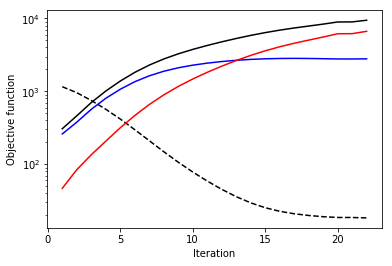

In [17]:
plt.semilogy(results[:,0], results[:,2], 'k--')
plt.semilogy(results[:,0], results[:,3], 'k')
plt.semilogy(results[:,0], results[:,4], 'b')
plt.semilogy(results[:,0], results[:,5], 'r')
# plt.legend(
#     ("$\phi_d$","$\phi_m$", "small", "smooth"), 
#     fontsize = 10, loc=4
# )
plt.xlabel("Iteration")
plt.ylabel("Objective function")

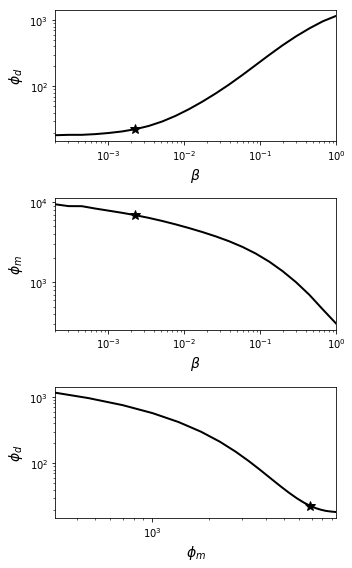

In [18]:
fig = plt.figure(figsize = (5, 8))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

ax1.plot(beta, phi_d, 'k-', lw=2, ms=4)
ax1.plot(beta[i_target], phi_d[i_target], 'k*', ms=10)
ax1.set_xlim(beta.min(), beta.max())
ax1.set_xlabel("$\\beta$", fontsize = 14)
ax1.set_ylabel("$\phi_d$", fontsize = 14)

ax2.plot(beta, phi_m, 'k-', lw=2)
ax2.plot(beta[i_target], phi_m[i_target], 'k*', ms=10)
ax2.set_xlim(beta.min(), beta.max())
ax2.set_xlabel("$\\beta$", fontsize = 14)
ax2.set_ylabel("$\phi_m$", fontsize = 14)

ax3.plot(phi_m, phi_d, 'k-', lw=2)
ax3.plot(phi_m[i_target], phi_d[i_target], 'k*', ms=10)
ax3.set_xlim(phi_m.min(), phi_m.max())
ax3.set_xlabel("$\phi_m$", fontsize = 14)
ax3.set_ylabel("$\phi_d$", fontsize = 14)
for ax in [ax1, ax2, ax3]:
    ax.set_xscale("log")
    ax.set_yscale("log")    
plt.tight_layout()

In [19]:
app_res = survey.dobs.reshape((survey.nFreq, 2))[:,0]
phase = survey.dobs.reshape((survey.nFreq, 2))[:,1]

In [20]:
from ipywidgets import interact, IntSlider, ToggleButtons

In [21]:
def view_1Dinversion_results(iteration, scale):
    fig = plt.figure(figsize = (10, 5))
    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(223)
    ax4 = plt.subplot(224)

    ax1.loglog(phi_m, phi_d, 'k-', lw=2)
    ax1.loglog(phi_m[i_target], phi_d[i_target], 'k*', ms=10)
    ax1.loglog(phi_m[iteration], phi_d[iteration], 'ro', ms=10)
    ax1.set_xlim(phi_m.min(), phi_m.max())
    ax1.set_xlabel("$\phi_m$", fontsize = 14)
    ax1.set_ylabel("$\phi_d$", fontsize = 14)
    ax1.set_xscale(scale)
    temp = xc[iteration]
    sigtrue = np.repeat(sigma, 2, axis=0)
    z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
    z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
    ax3.plot(-z, sigtrue, 'k', lw=2)
    ax3.plot(-mesh.vectorCCx, np.exp(temp), 'k--', lw=2)
    ax3.set_xscale("linear")
    ax3.set_yscale("log")
    ax3.set_ylabel("Conductivity (S/m)")
    ax3.set_xlabel("Depth (m)")
    ax3.grid(True, which='both')
    ax3.set_ylim(2e-3, 2e-1)
    ax3.set_xlim((-z).min(), max_depth_core)

    dpred = survey.dpred(xc[iteration])
    app_res_pred = dpred.reshape((survey.nFreq, 2))[:,0]
    phase_pred = dpred.reshape((survey.nFreq, 2))[:,1]
    ax2.loglog(frequency, app_res, 'k-', lw=2)
    ax2.loglog(frequency, app_res_pred, 'kx', markeredgewidth=1)
    ax2.grid(True, which='both')
    ax2.set_xlim(frequency.max(), frequency.min())
    ax2.set_ylim(10, 3e2)
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("$\\rho_a \ (\Omega m)$", fontsize = 14)

    ax4.semilogx(frequency, phase, 'k-', lw=2)
    ax4.semilogx(frequency, phase_pred, 'kx', markeredgewidth=1)

    ax4.grid(True, which='both')
    ax4.set_xlim(frequency.max(), frequency.min())
    ax4.set_xlabel("Frequency (Hz)")
    ax4.set_ylabel("Phase (degree)")
    plt.tight_layout()
    plt.show()
    
interact(view_1Dinversion_results, 
         iteration=IntSlider(min=0, max=results.shape[0]-1, step=1, value=0),
         scale=ToggleButtons(options=["linear", "log"], value="log"))

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.view_1Dinversion_results>

In [22]:
def MT1D_inv_results(xc, iteration):
    fig, ax = plt.subplots(3, 1, figsize = (8, 9))

    temp = xc[iteration]
    sigtrue = np.repeat(sigma, 2, axis=0)
    z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
    z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
    ax1.plot(-z, sigtrue, 'k', lw=2)
    ax1.plot(-mesh.vectorCCx, np.exp(temp), 'k--', lw=2)
    ax1.set_xscale("linear")
    ax1.set_yscale("log")
    ax1.set_ylabel("Conductivity (S/m)")
    ax1.set_xlabel("Depth (m)")
    ax1.grid(True, which='both')
    ax1.set_ylim(2e-3, 4e-1)
    ax1.set_xlim((-z).min(), max_depth_core)

    dpred = survey.dpred(xc[iteration])
    app_res_pred = dpred.reshape((survey.nFreq, 2))[:,0]
    phase_pred = dpred.reshape((survey.nFreq, 2))[:,1]
    ax2.loglog(frequency, app_res, 'k-', lw=2)
    ax2.loglog(frequency, app_res_pred, 'kx', markeredgewidth=1)
    ax2.grid(True, which='both')
    ax2.set_xlim(frequency.max(), frequency.min())
    ax2.set_ylim(10, 3e2)
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("$\\rho_a \ (\Omega m)$", fontsize = 14)

    ax3.semilogx(frequency, phase, 'k-', lw=2)
    ax3.semilogx(frequency, phase_pred, 'kx', markeredgewidth=1)

    ax3.grid(True, which='both')
    ax3.set_xlim(frequency.max(), frequency.min())
    ax3.set_xlabel("Frequency (Hz)")
    ax3.set_ylabel("$\phi \ (^{\circ})$", fontsize = 14)
    plt.tight_layout()

In [23]:
m0 = np.log(0.01) * np.ones(mesh.nC)
xc_fixed, save_fixed, reg = run_MT1Dinv(prob, survey, m0,
                                   beta0=beta[i_target]*10, coolingFactor=2., coolingRate=3,
                                   alpha_s=1., alpha_x=1.,
                                   use_target=True)

TypeError: run_MT1Dinv() got an unexpected keyword argument 'alpha_x'

In [ ]:
smooth = reg.objfcts[1]

In [ ]:
reg.regmesh

In [ ]:
MT1D_inv_results(xc_fixed, -1)

In [ ]:
m0 = np.log(0.01) * np.ones(mesh.nC)
xc_fixed, save_fixed, reg = run_MT1Dinv(prob, survey, m0,
                                   coolingFactor=2., coolingRate=3,
                                   alpha_s=1., alpha_x=0., beta0 = beta[i_target]*10,
                                   use_target=True, use_betaest=True)

In [ ]:
MT1D_inv_results(xc_fixed, -1)

In [ ]:
m0 = np.log(0.01) * np.ones(mesh.nC)
xc_fixed, save_fixed, reg = run_MT1Dinv(prob, survey, m0,
                                   coolingFactor=2., coolingRate=3,
                                   alpha_s=0., alpha_x=1., beta0 = beta[i_target]*10,
                                   use_target=True, use_betaest=True)

In [ ]:
MT1D_inv_results(xc_fixed, -1)